---
layout: post
title:  "PR vs ROC Curves - Which to Use?"
desc: "Exploring the difference between the graphs using python."
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/pr_vs_roc"

math: true
---

PR curves and ROC diagrams are presented everywhere in the machine learning sphere, and are often used relatively interchangably. In many cases, this is fine, because they are both providing information on the general question "How good is my classifier?". But like many things which are often fine to do, there are cases where we'd want to specifically show either a PR or ROC curve.

So in the next few sections, we'll generate a mock dataset, generate PR and ROC curves for them for two different classifiers, go into the definition of both of PR and ROC curves (both the intuition and mathematics), and then we'll go how they subtly differ with another code example.


# A toy example

Let's utilise the `make_moon` function from `sklearn` to get some toy data, and then super quickly train both a logistic regression and random forest classifier on it.

In [57]:
# Remove
from base import *
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#14b309', '#841ee3', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

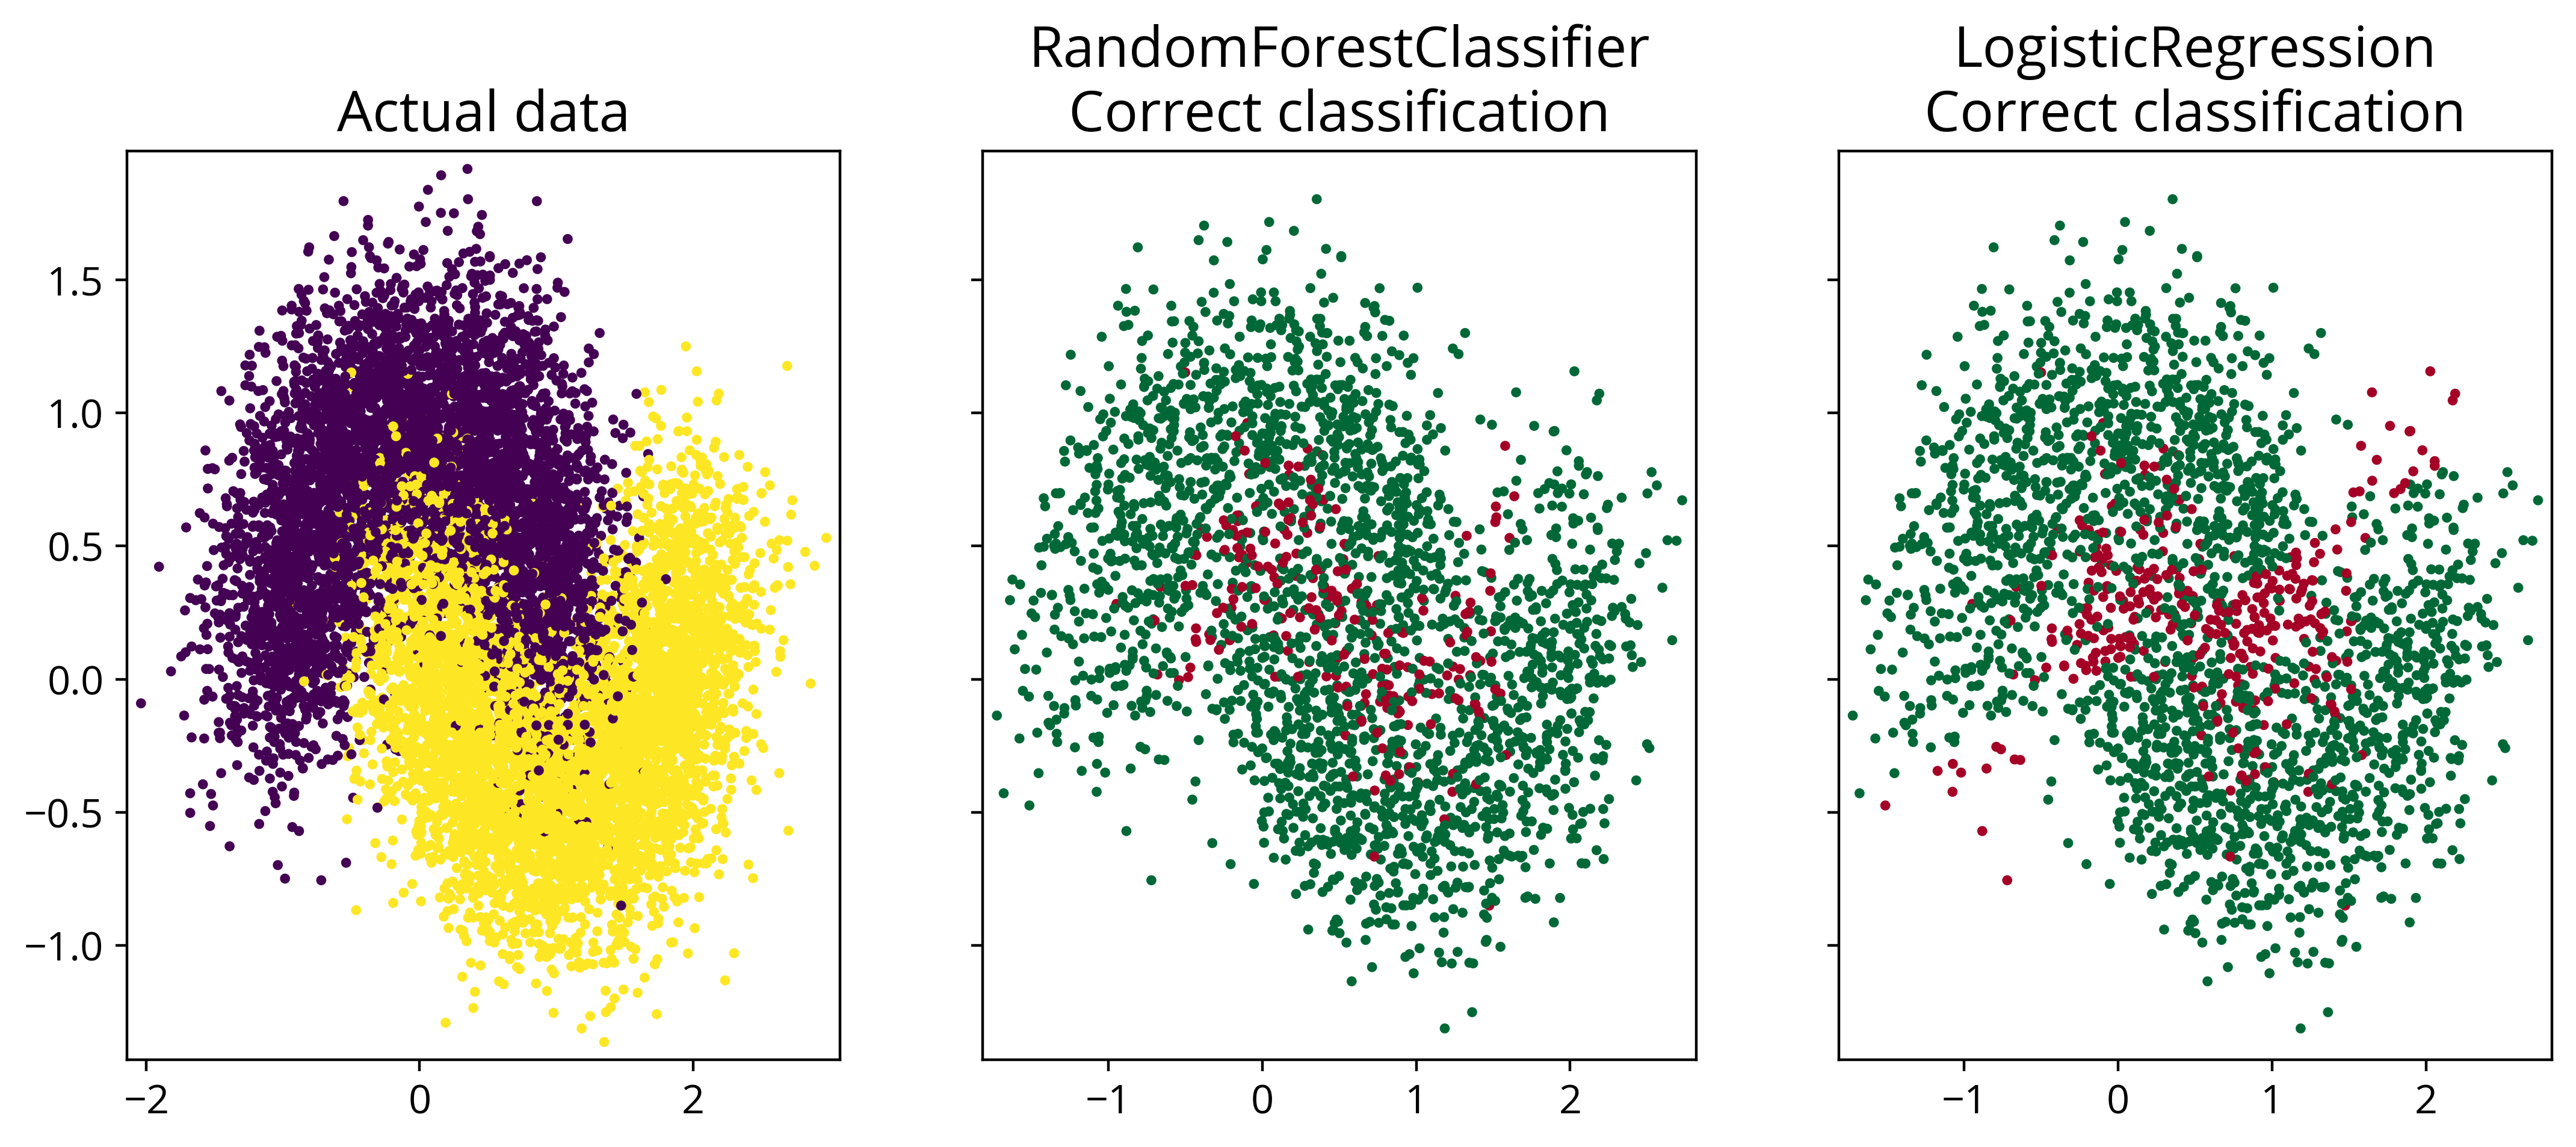

In [58]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Generate some mock data
X, y = make_moons(n_samples=10000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit two basic models
models = [RandomForestClassifier(), LogisticRegression()]
results = []
for m in models:
    m.fit(X_train, y_train)
    results.append(m.predict(X_test))

# Plot results
fig, axes = plt.subplots(ncols=1 + len(models), sharey=True, figsize=(13, 5))
axes[0].scatter(X[:, 0], X[:, 1], c=y)
axes[0].set_title("Actual data")
for ax, m, r in zip(axes[1:], models, results):
    ax.scatter(X_test[:, 0], X_test[:, 1], c=(r == y_test), cmap="RdYlGn")
    ax.set_title(f"{m.__class__.__name__}\nCorrect classification");

So here we have some simple moon data, two classifiers, one naively looks better than the other, we want to determine the threshold in which its internal "probability" results in us classifying into one group or another. Where we set that limit will determine, how much contamination is in the positives, vs positives we failed to get.


# What is a PR Curve?

A **Precision-Recall** curve is exactly what it sounds like. It allows us to see the relationship between the **precision** (the number of true positives over the total number of positives - true positives and false positives combined) and the **recall** (number of true positives over the total number of real true values - the true positives and false negatives combined).

To rephrase:

* Precision is asking how many true successes are in all our reported successes
* Recall is out of all the true values that went in, how many did we successfully get back out.

Now there is obviously going to be an inverse relationship out. If we have increase our precision, that means we want to remove **False Positives** from our predictions, so we'd throw out more events. But because some of the events we throw out might be true events, we would decrease our **recall**. So we want to hit a sweet spot, and where that is depends on your business case.

We can generate a PR curve easily in sklearn like so:

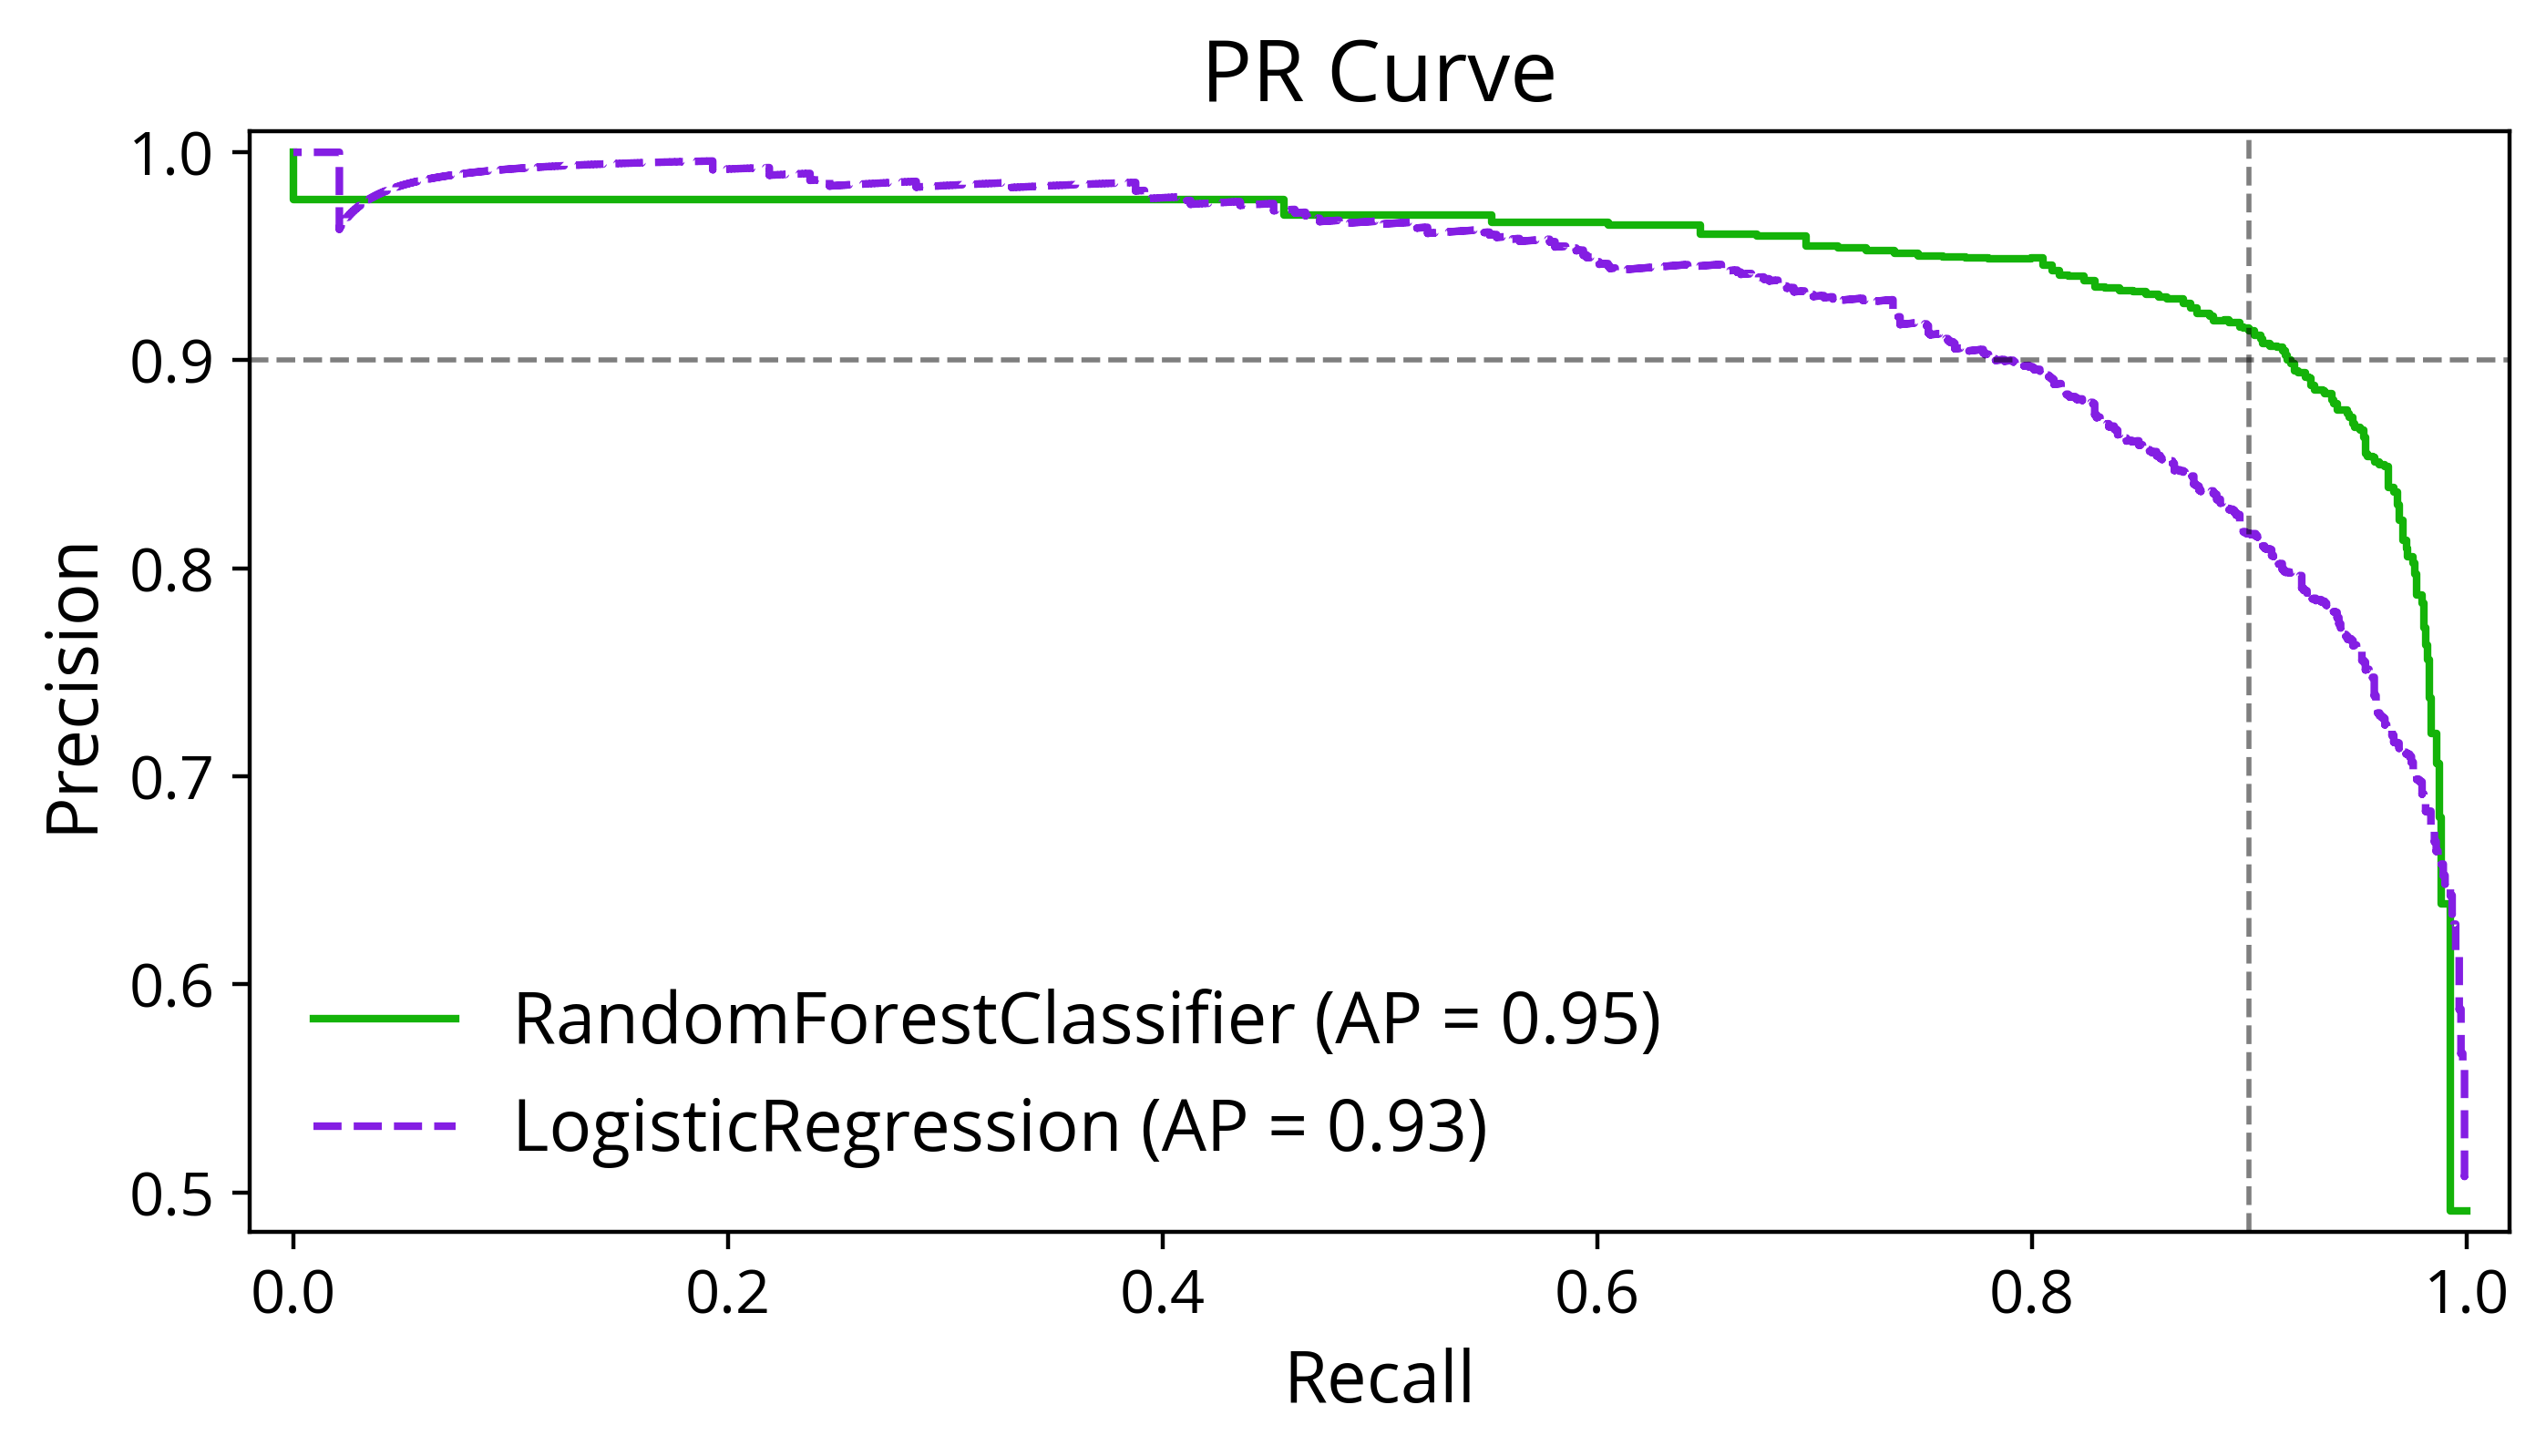

In [59]:
from sklearn.metrics import plot_precision_recall_curve
# Can do it manually by importing precision_recall_curve

fig, ax = plt.subplots()
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=ax)
ax.axhline(0.9, c='k', ls="--", lw=1, alpha=0.5)
ax.axvline(0.9, c='k', ls="--", lw=1, alpha=0.5)
ax.set_title("PR Curve");

The "AP" in the plot is the average precision, weighted by the change in recall. [See this link for details](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). The important thing is to note the characteristic curve we see, and that what you want is for your curve to get as high up in the upper right corner as possible. Here, we can see that we could pick a classification threshold for the Random Forest Classifier that would grant us a precision of > 90% and still have a recall of also above 90% (the dashed lines are at the 90% mark, and you can see the curve gets aboe both of them).

# What is a ROC curve?

A **receiver operating characteristic curve** (ROC curve) is similar to a PR curve. Instead of plotting precision vs recall, we plot the **True Positive Rate** against the **False Positive Rate**. The TPR is just another name for **recall** (its also called sensitivity). The FPR (also known as fallout, and 1 - TNR, aka 1 - specificity) is defined as the number false positivies over the total number of negatives (false positives plus true negatives).

To rephrase:

* TPR is recall: out of all the true values that went in, how many did we successfully get back out.
* FPR is the chance we contaminate our sample with a false positive.

We can generate a ROC curve easily using sklearn as well:


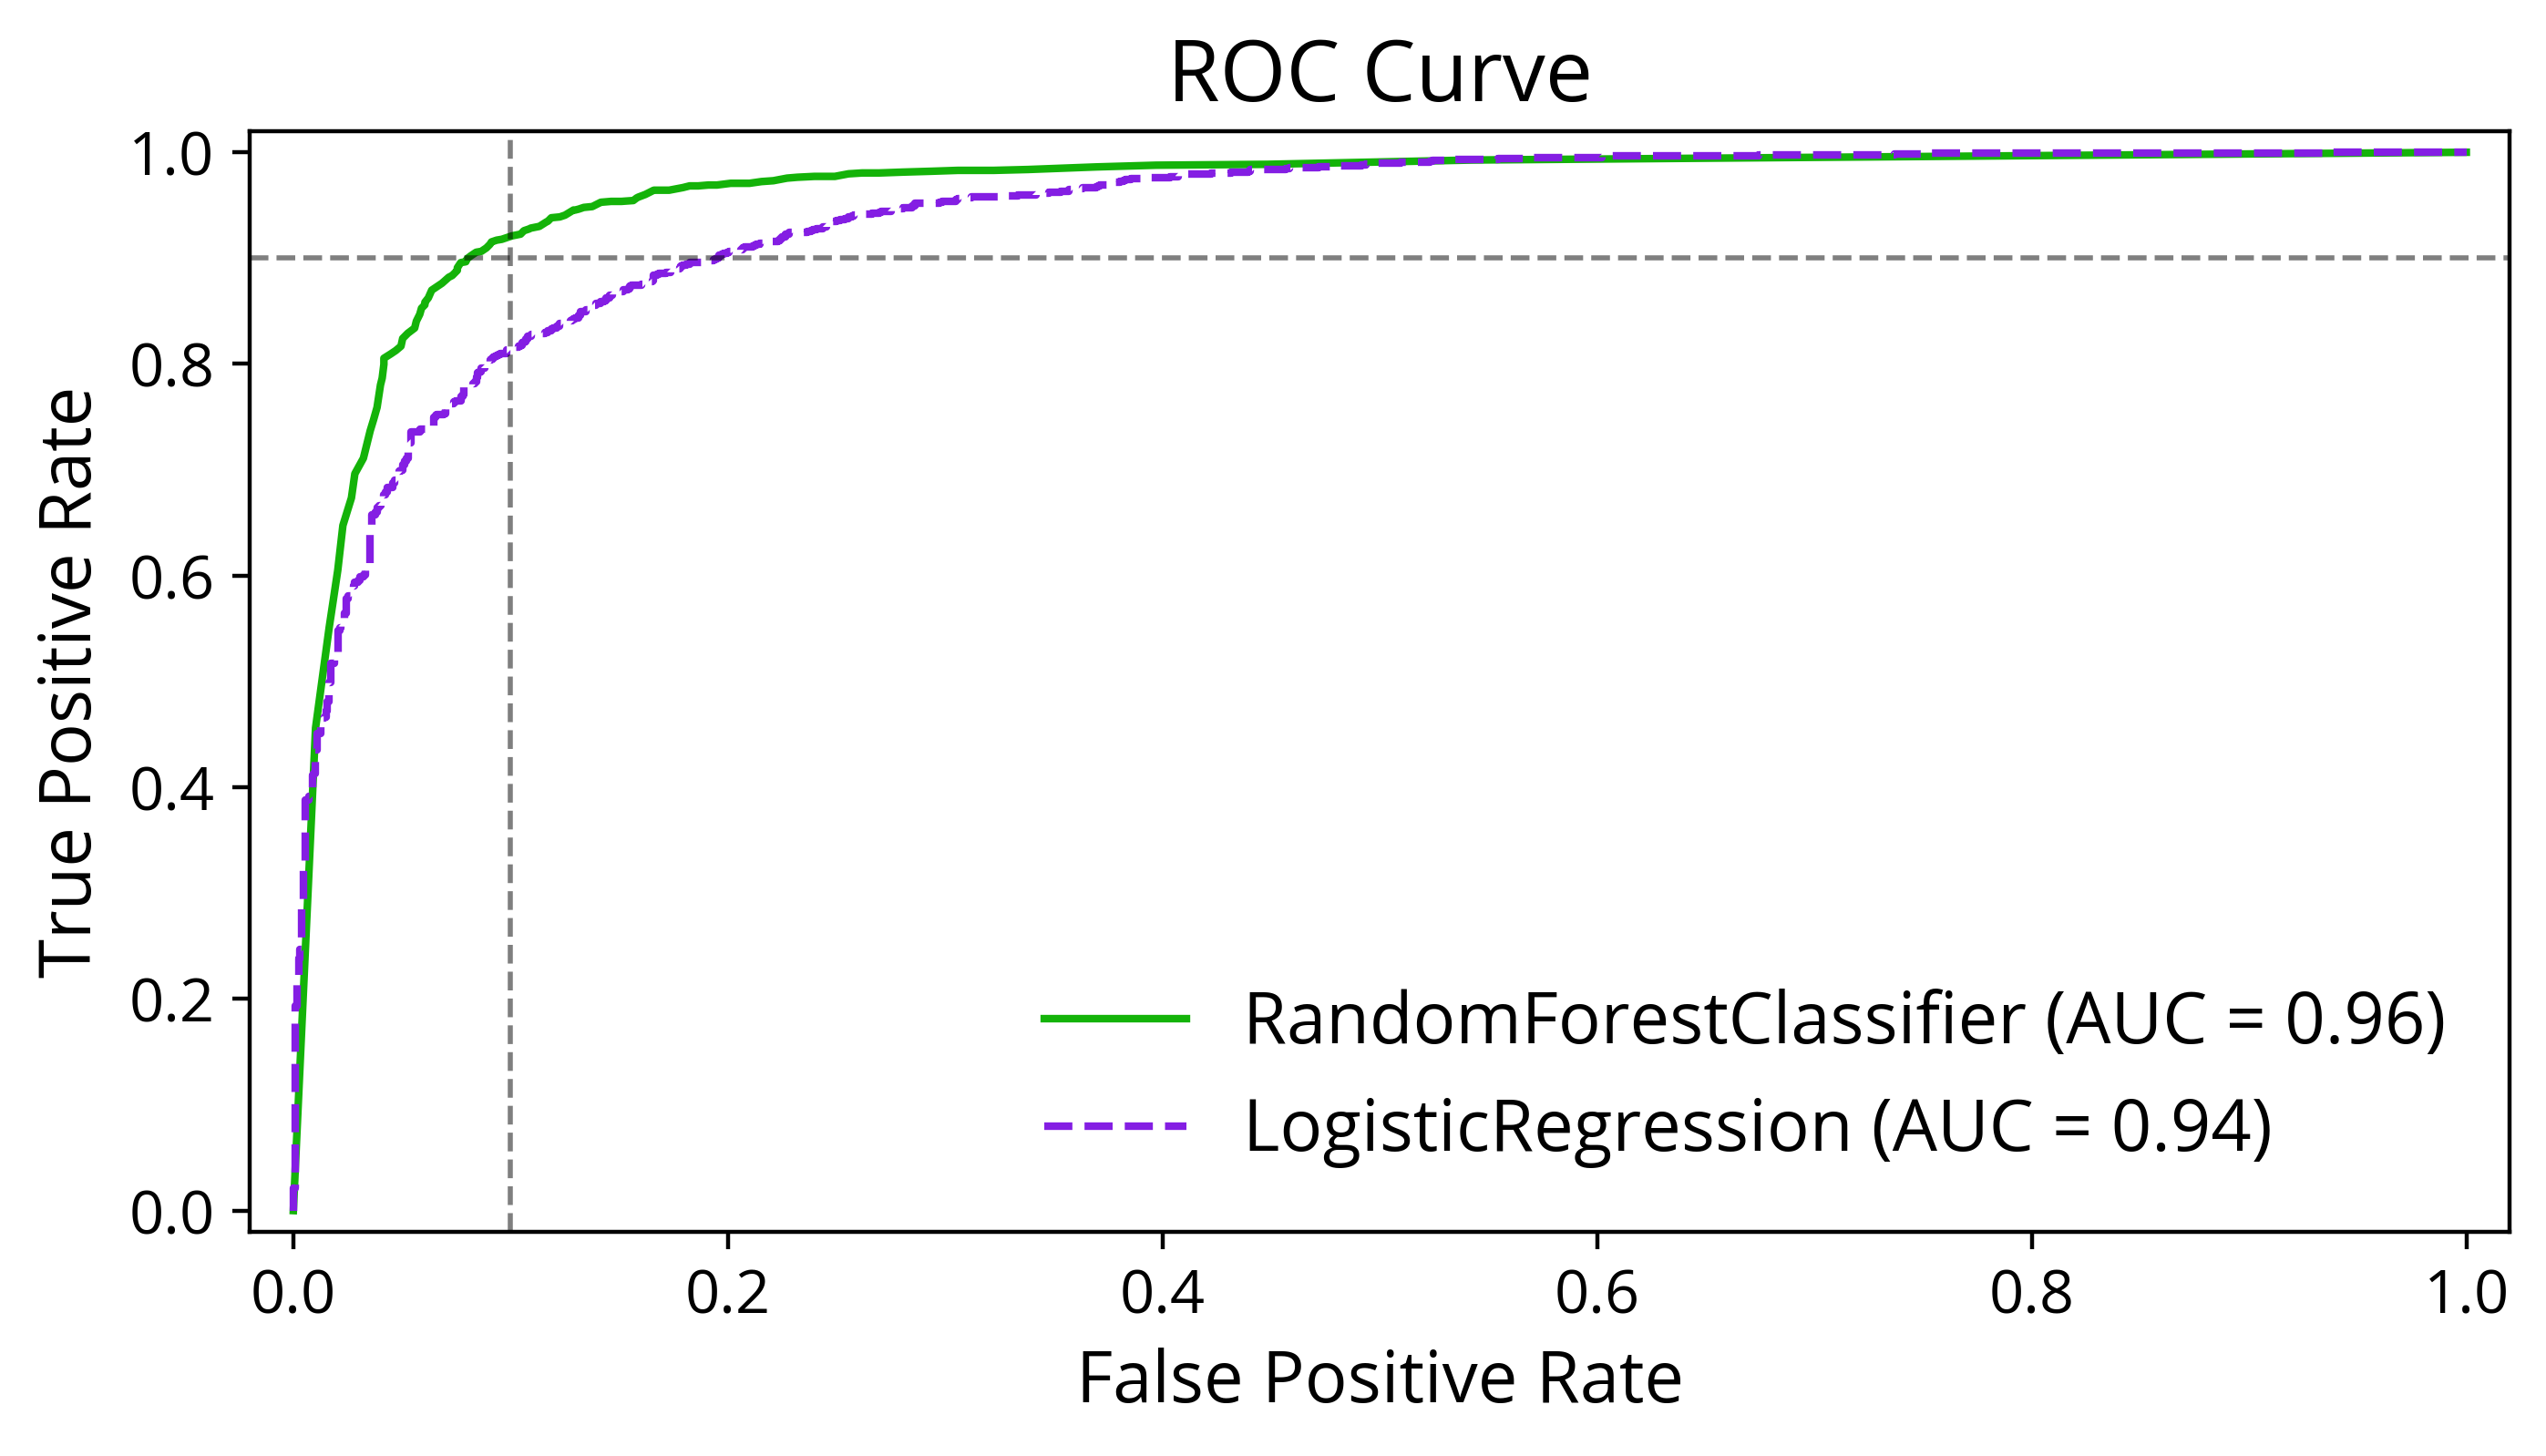

In [60]:
from sklearn.metrics import plot_roc_curve
# Can do it manually by importing roc_curve

fig, ax = plt.subplots()
for m in models:
    plot_roc_curve(m, X_test, y_test, ax=ax)
ax.axhline(0.9, c='k', ls="--", lw=1, alpha=0.5)
ax.axvline(0.1, c='k', ls="--", lw=1, alpha=0.5)
ax.set_title("ROC Curve");

In this plot, we want to get in the top left corner, not the top right one. The dashed lines show us that our current RF model can achieve a true positive rate of >90%, with a false positive rate of <10%. 

And all things considered, it looks very similar to the PR curve, just flipped around. But there is an important difference that isn't just semantics.

# Examining the difference

Let's make this a little more formal, and take a step back to the three things we care about that make up these two plots. Let us quickly denote $Y$ the *true* label, and $\hat{Y}$ our predicted label. The hat operator is often used as our "observation" or estimate, and we would write "the probability of $x$ given $y$" as $P(x\|y)$.

* **Precision**: How many true successes are in all of our labeled successes. $P(Y=1\|\hat{Y}=1)$.
* **Recall/TPR**: Out of all the true values that went in, how many came out.  $P(\hat{Y}=1\|Y=1)$.
* **FPR**: The chance we contaminate our sample with a false positive. $P(\hat{Y}=1\|Y=0)$.


The important difference to note is that for the ROC curve, (TPR and FPR), the actual truth values are on the right hand side (they are conditioned on). For the PR curve, the precision has the predicted label on the right hand side. So one term is conditioned on the truth, the other on the estimate.

When will this make a difference?

When the classes are imbalanced, or you care more about getting a true positive than a false negative. Imagine the difference between a recommendor system that might not recommend you a movie you actually would have liked (no big deal), and medical imaging algorithm that failes to detect cancer when its present in the image (a very big deal).

Imagine if we look at a dataset with 100 cases in it. Either movies you want to watch, or people with cancer. And there are 100000 negatives (bad movies, healthy patients). Two classifiers, A and B, are run, and both get 99 out of the 100 cases correct; their recall is the same. But classifier A predicts 150 outcomes in total (99 true positives, 51 false positives), and classifier B predicts 1000 cases (99 true positives, 901 false positives). Their precision and FPR is different.

* **Classifier A**: Recall=0.99, Precision=99/150=0.66, FPR=51/(51+10000)=0.0005
* **Classifier B**: Recall=0.99, Precision=99/1000=0.099, FPR=901/(901+10000)=0.008

By looking at the ROC curve (Recall and FPR), the two classifiers look like they have similarly great performance! Same recal, and the FPR is absolutely tiny! But if we look at the PR curve (Recall and Precision), they look totally difference - one has a precision of 0.66, the other <0.1!

With these sort of imbalanced class numbers, we can see why we might prefer PR curves in these cases.

In fact, lets quickly update the code above to produce an imbalanced set, and run two different classifiers, so we can compare the curves:


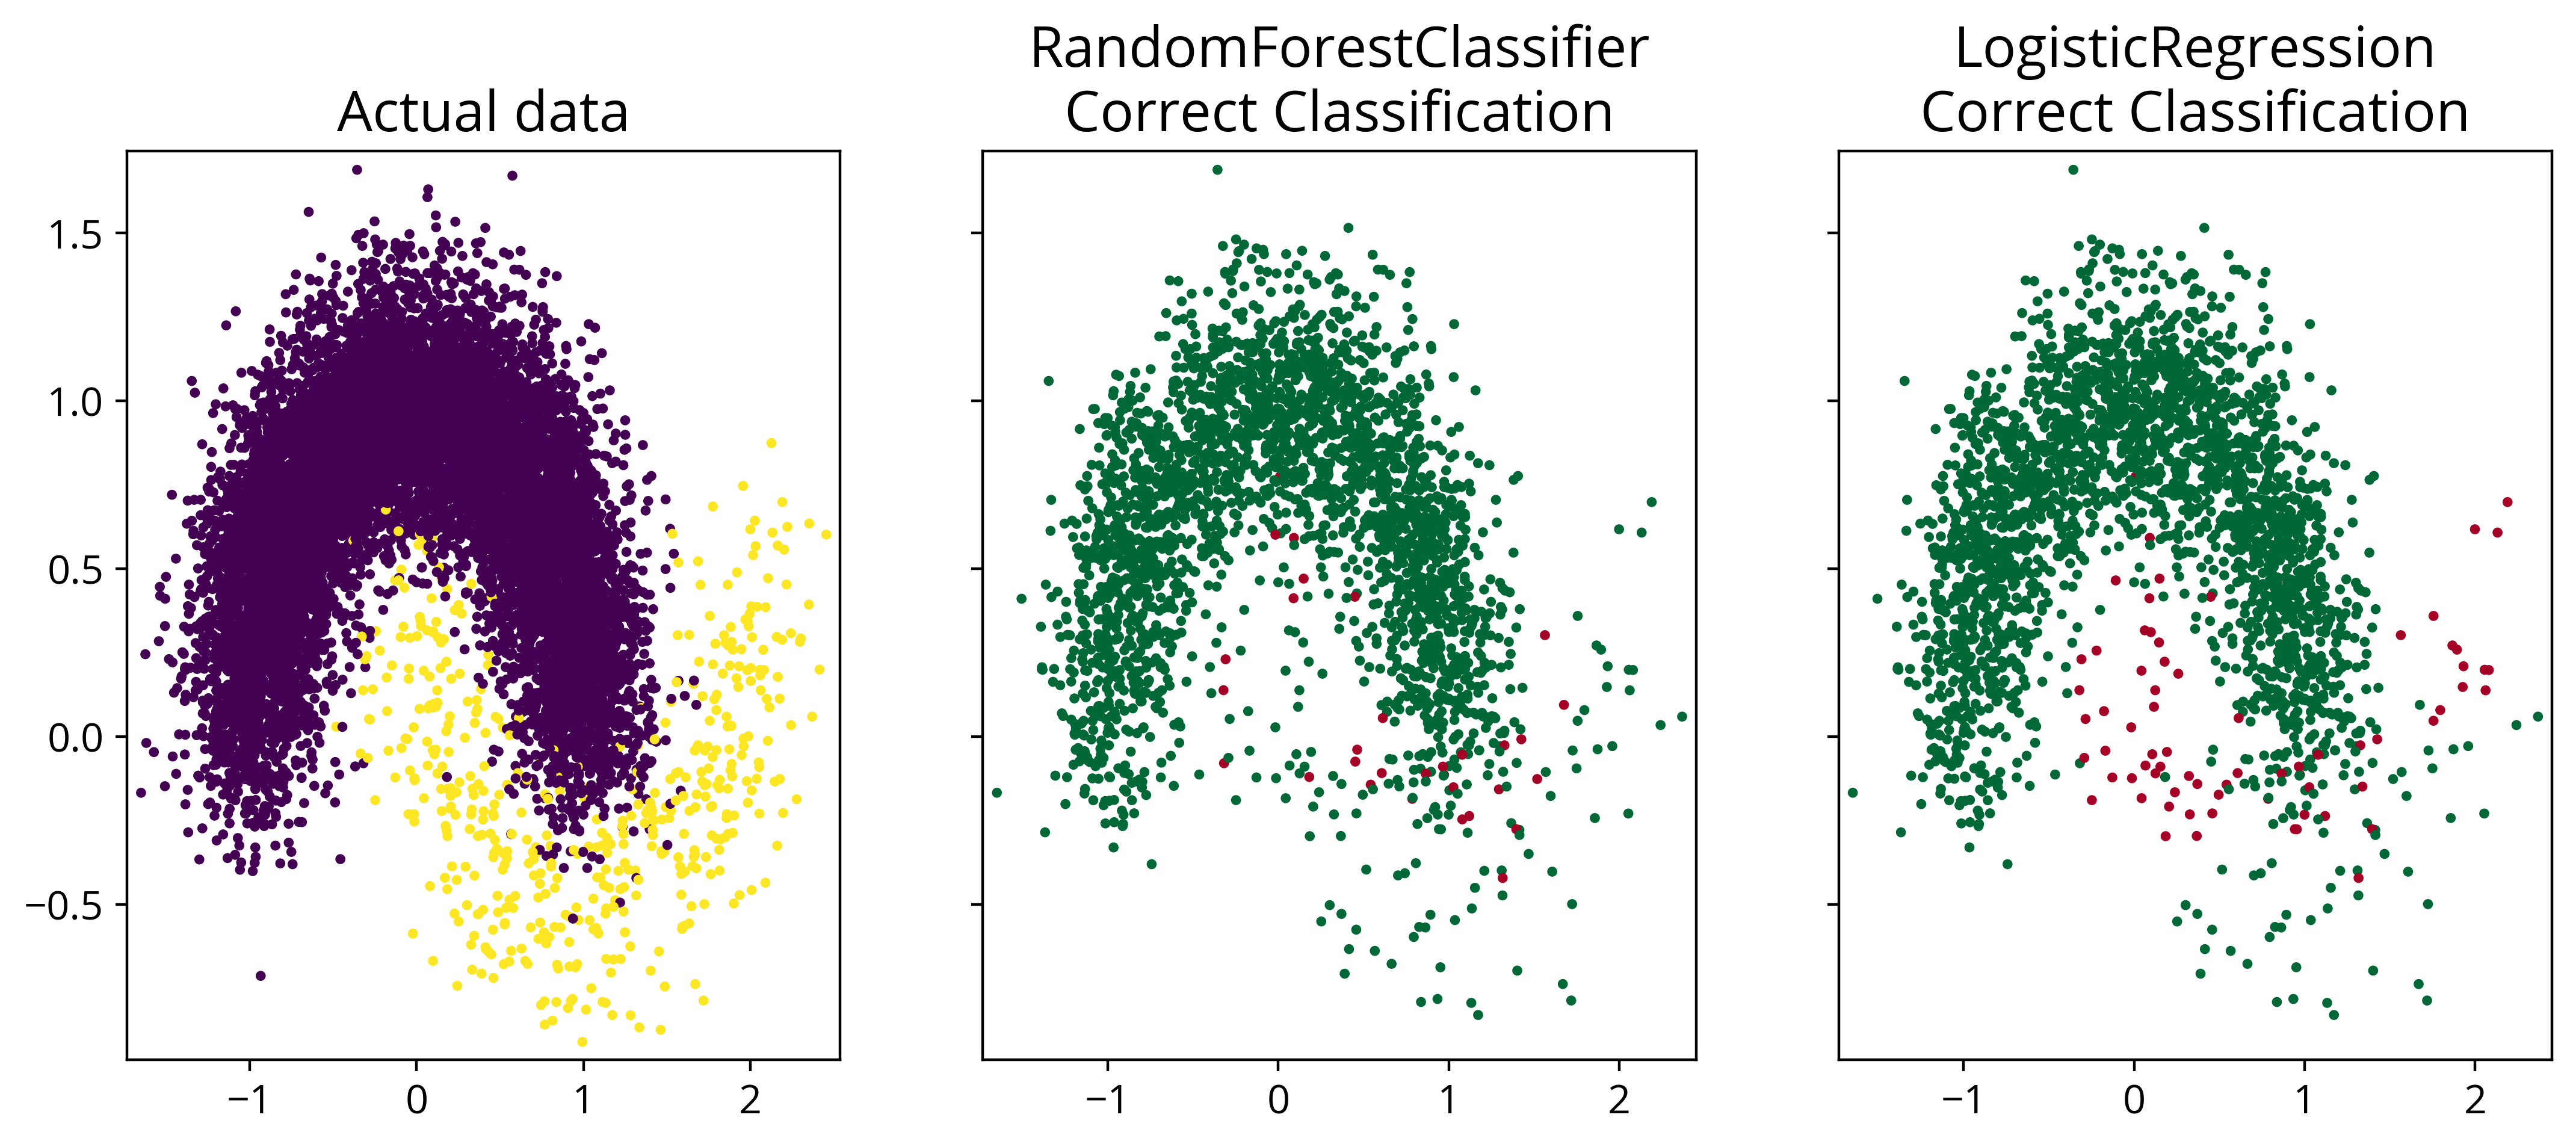

In [61]:
# Generate some mock data
X, y = make_moons(n_samples=(10000, 500), noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit some basic random forest
models = [RandomForestClassifier(), LogisticRegression()]
results = []
for m in models:
    m.fit(X_train, y_train)
    results.append(m.predict(X_test))
    
# Plot results
fig, axes = plt.subplots(ncols=len(models)+1, sharey=True, figsize=(13, 5))
axes[0].scatter(X[:, 0], X[:, 1], c=y)
axes[0].set_title("Actual data")
for ax, m, r in zip(axes[1:], models, results):
    ax.scatter(X_test[:, 0], X_test[:, 1], c=(r == y_test), cmap="RdYlGn")
    ax.set_title(f"{m.__class__.__name__}\nCorrect Classification");

In this example, the classes are imbalanced by a factor of 20, so lets see if the imbalanced classes cause a large discrepancy now in the PR curve than in the ROC curve:

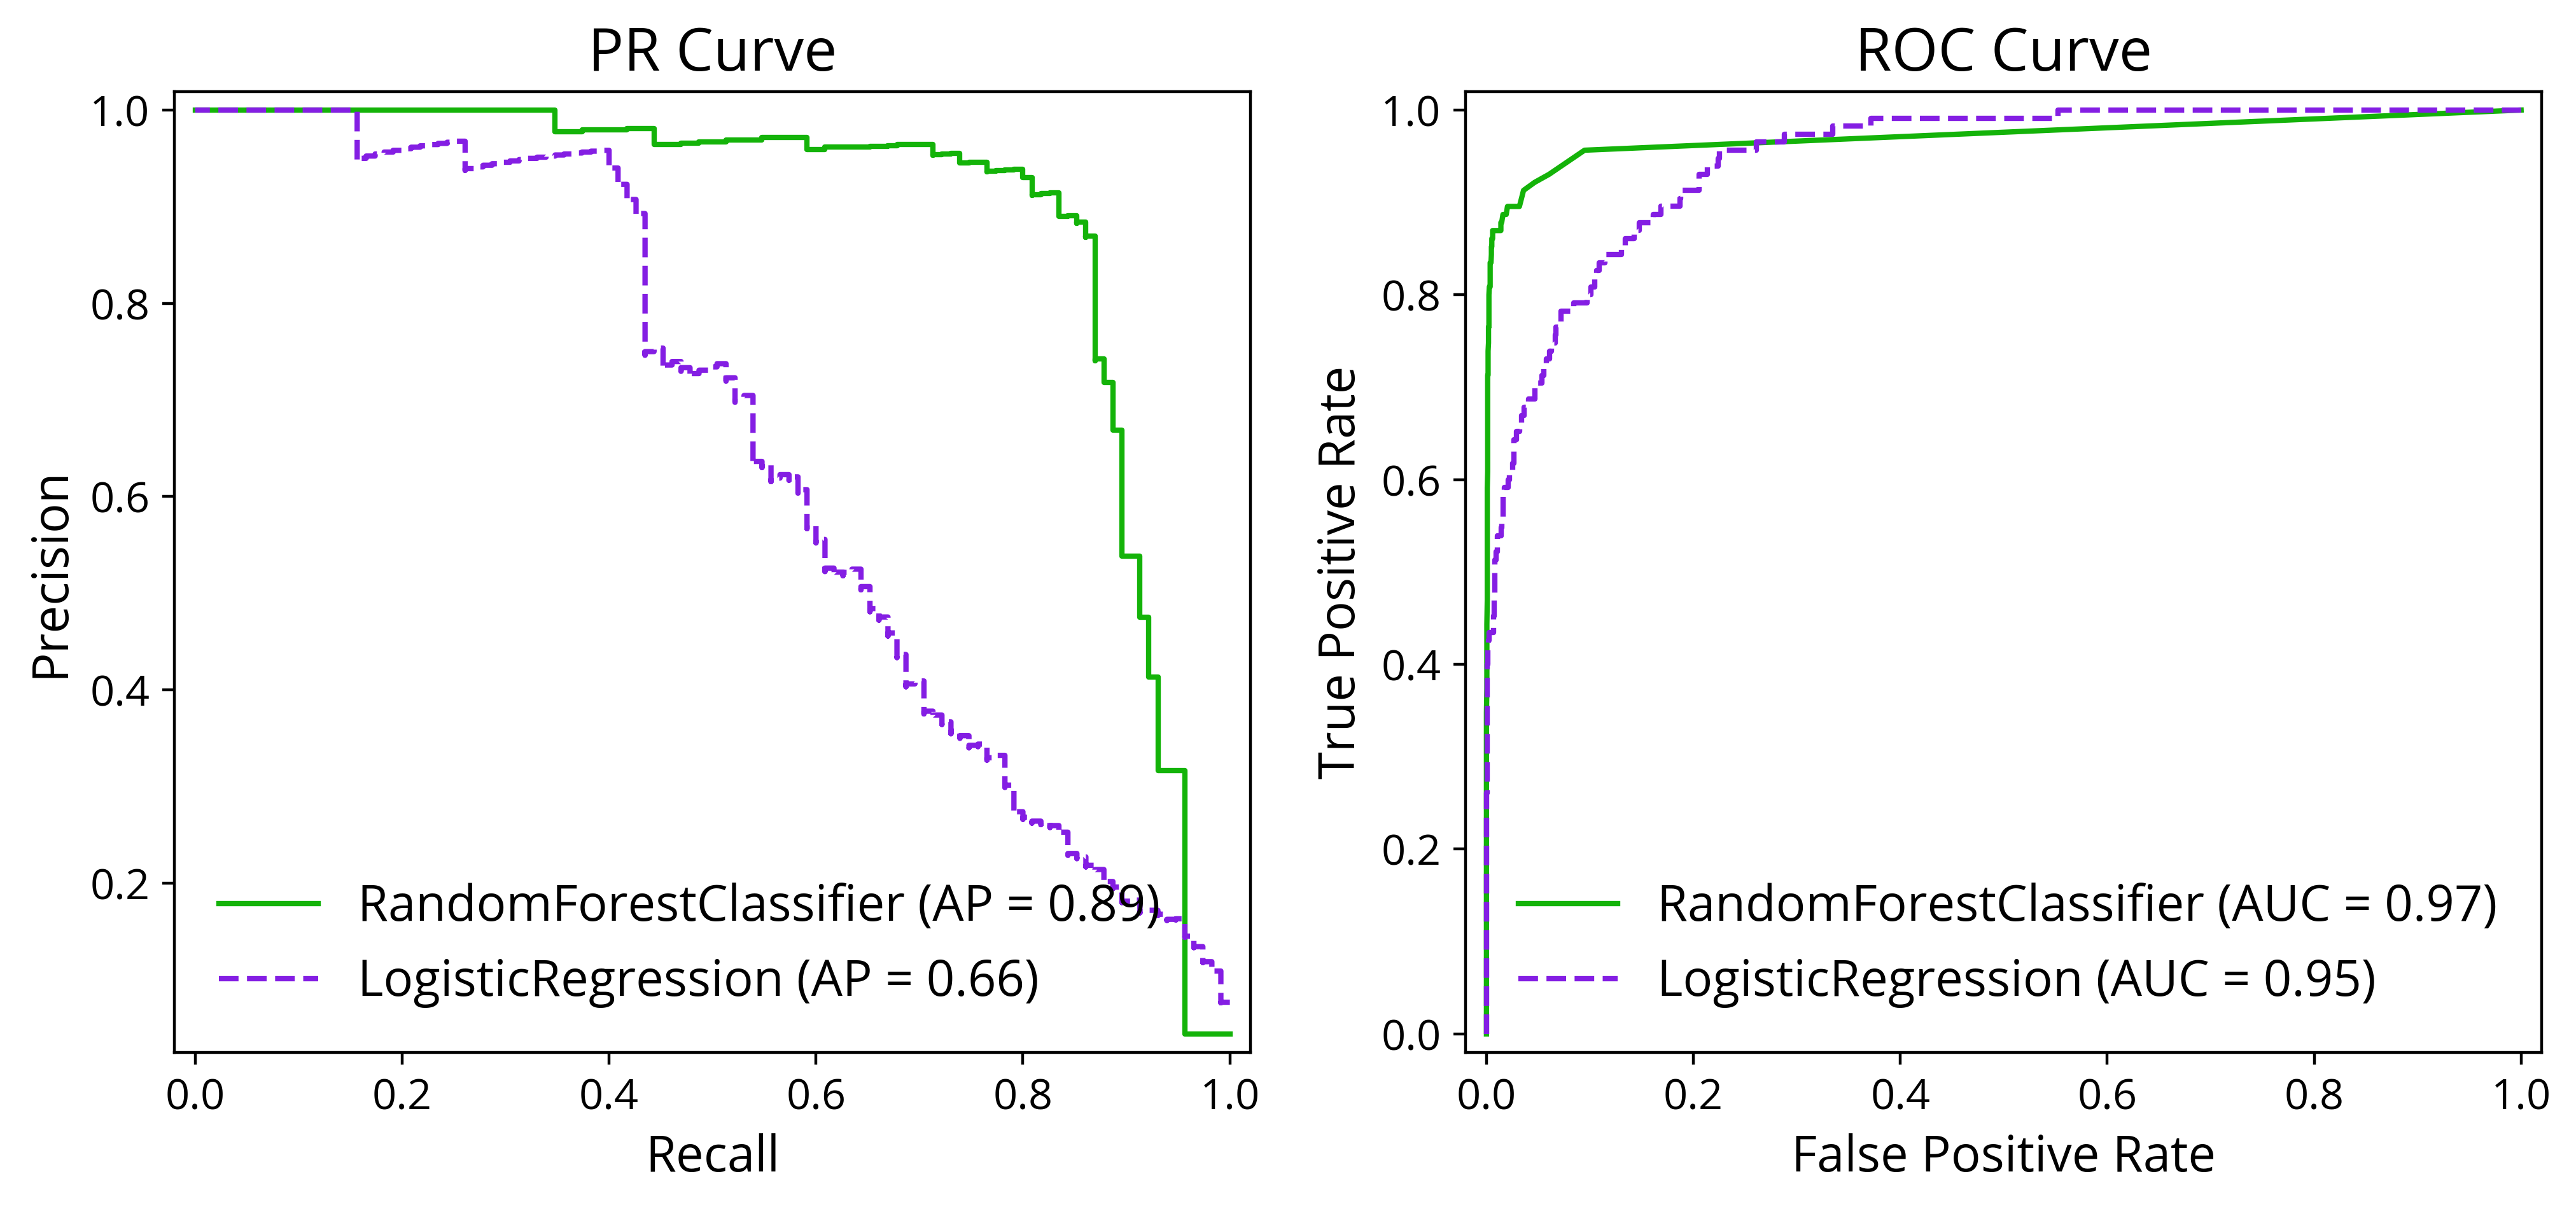

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=axes[0])
    plot_roc_curve(m, X_test, y_test, ax=axes[1])
axes[0].set_title("PR Curve"), axes[1].set_title("ROC Curve");

!!!main

Fantastic, just as we expect. The ROC shows that, in general, the Random Forest performs better than the Logistic Regression (if, of course, we choose to use the TPR and FPR to measure performance). And the PR curve takes our specific class imbalance into account and shows the larger difference between in performance between the two classifiers due to the large difference in precision between them.

# Summary

In general, the ROC curve answers the question of how well the model performs with no knowledge of the class imbalance, whilst the PR curve uses our estimated class imbalance baseline to inform us of how well our model performs, given the specific imbalance we provided it.

For more reading on this topic, I recommend the following resources and threads, many of which inspire the explanations above:

* [Machine Learning Mastery - Jason Brownlee](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
* [Towards Data Science - Carlos Azevedo](https://towardsdatascience.com/on-roc-and-precision-recall-curves-c23e9b63820c)
* [Stats Stack Exchange - numerous](https://stats.stackexchange.com/questions/7207/roc-vs-precision-and-recall-curves)

I hope this page and the resources above are useful!